In [86]:
from pandas import read_parquet, concat
from pathlib import Path
from json import load
import seaborn as sns
from matplotlib import pyplot as plt

In [87]:
data_path = Path("data/matmul_matrix_matrix")

def load_scipy_data(scipy_paths):
   scipy_dfs = []
   for scipy_timing_path in scipy_paths:
      scipy_df = read_parquet(scipy_timing_path)
      scipy_df["Matrix name"] = scipy_timing_path.parent.stem.capitalize().replace("_", " ")
      scipy_metadata_path = next(data_path.rglob(f"{scipy_timing_path.stem}*.json"))
      if scipy_metadata_path:
         with scipy_metadata_path.open() as file_handle:
            scipy_metadata = load(file_handle)
         scipy_df["number"] = scipy_metadata.get("number")
         scipy_df["repeat"] = scipy_metadata.get("repeat")
         scipy_df["function_iterations"] = scipy_metadata.get("function_iterations")
      scipy_dfs.append(scipy_df)
   return concat(scipy_dfs).reset_index()

def load_cupy_data(cupy_paths):
   cupy_dfs = []
   for cupy_timing_path in cupy_paths:
      cupy_df = read_parquet(cupy_timing_path)
      cupy_df["Matrix name"] = cupy_timing_path.parent.stem.capitalize().replace("_", " ")
      cupy_metadata_path = next(data_path.rglob(f"{cupy_timing_path.stem}*.json"))
      if cupy_metadata_path:
         with cupy_metadata_path.open() as file_handle:
            cupy_metadata = load(file_handle)
         cupy_df["number"] = cupy_metadata.get("number")
         cupy_df["repeat"] = cupy_metadata.get("repeat")
         cupy_df["warmup"] = cupy_metadata.get("warmup")
      cupy_dfs.append(cupy_df)
   return concat(cupy_dfs).reset_index()

In [88]:
scipy_timing_paths = data_path.rglob("*cpu*.parquet")
scipy_timings = load_scipy_data(scipy_timing_paths)
scipy_timings["duration_normalised"] = scipy_timings["duration"] / scipy_timings["number"] / scipy_timings["function_iterations"]
scipy_fastest = scipy_timings.loc[scipy_timings.groupby(["Matrix name", "sparse_format"])["duration_normalised"].idxmin()]
scipy_fastest["duration_normalised"] = scipy_fastest["duration_normalised"] * 1_000
scipy_fastest

,index,device,operation_method,sparse_format,duration,Matrix name,number,repeat,function_iterations,duration_normalised
2,2,cpu,once,bsr,2.394533,Dairy cow acyclic,1,10,32,74.829163
11,1,cpu,once,csc,1.485996,Dairy cow acyclic,1,10,32,46.437372
25,5,cpu,once,csr,1.853223,Dairy cow acyclic,1,10,32,57.913212
33,3,cpu,once,bsr,4.356780,Dairy cow cyclic,1,10,32,136.149381
45,5,cpu,once,csc,2.697230,Dairy cow cyclic,1,10,32,84.288441
59,9,cpu,once,csr,3.729241,Dairy cow cyclic,1,10,32,116.538781


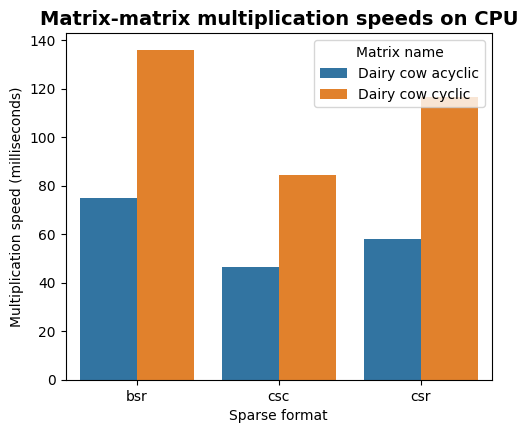

In [92]:
f, ax = plt.subplots(figsize=(5.5, 4.5))
sns.barplot(scipy_fastest, x="sparse_format", y="duration_normalised", hue="Matrix name", ax=ax)
ax.set_title("Matrix-matrix multiplication speeds on CPU", fontdict={"fontsize": 14, "fontweight": "bold"})
ax.set_xlabel("Sparse format")
ax.set_ylabel("Multiplication speed (milliseconds)")
plt.savefig("matmul_matrix_matrix_cpu.svg")
plt.show()
plt.close()

In [90]:
cupy_timing_paths = data_path.rglob("*gpu*.parquet")
cupy_timings = load_cupy_data(cupy_timing_paths)
# cupy_timings
cupy_timings["duration_normalised"] = cupy_timings["duration_gpu"] / cupy_timings["number"]
cupy_fastest = cupy_timings.loc[cupy_timings.groupby(["Matrix name", "sparse_format"])["duration_normalised"].idxmin()]
cupy_fastest["duration_normalised"] = cupy_timings["duration_normalised"] * 1_000
cupy_fastest

,index,device,operation_method,sparse_format,duration_cpu,duration_gpu,Matrix name,number,repeat,warmup,duration_normalised
1,1,gpu,iterative,coo,0.965537,0.967940,Dairy cow acyclic,32,10,20,30.248119
15,5,gpu,iterative,csc,0.289005,0.291429,Dairy cow acyclic,32,10,20,9.107150
22,2,gpu,iterative,csr,0.246570,0.248986,Dairy cow acyclic,32,10,20,7.780802
32,2,gpu,iterative,coo,1.201840,1.209272,Dairy cow cyclic,32,10,20,37.789761
47,7,gpu,iterative,csc,0.527958,0.535420,Dairy cow cyclic,32,10,20,16.731876
51,1,gpu,iterative,csr,0.552451,0.559906,Dairy cow cyclic,32,10,20,17.497049


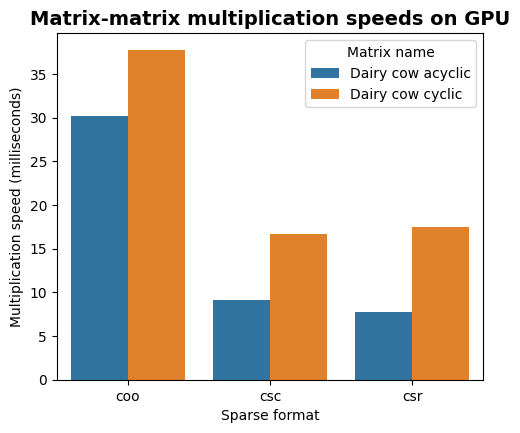

In [95]:
f, ax = plt.subplots(figsize=(5.5, 4.5))
sns.barplot(cupy_fastest, x="sparse_format", y="duration_normalised", hue="Matrix name", ax=ax)
ax.set_title("Matrix-matrix multiplication speeds on GPU", fontdict={"fontsize": 14, "fontweight": "bold"})
ax.set_xlabel("Sparse format")
ax.set_ylabel("Multiplication speed (milliseconds)")
plt.savefig("matmul_matrix_matrix_gpu.svg")
plt.show()
plt.close()